In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

%matplotlib inline

In [2]:
sns.__version__

'0.11.1'

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

## Ribbons

In [4]:
ribbons_baseline = pd.read_csv('ribbon_controls.csv', delimiter=',', header=None).T

# # rename columns
ribbons_baseline.columns = ribbons_baseline.iloc[0]
ribbons_baseline.columns = ribbons_baseline.columns.fillna('dummy')
ribbons_baseline.columns.values[0] = 'Substrain'
ribbons_baseline.columns.values[1] = 'ID'
ribbons_baseline.drop(0, inplace=True)

# stack values
ribbons_baseline = pd.DataFrame(ribbons_baseline.set_index(['Substrain', 'ID']).stack())
ribbons_baseline.columns = ['Synaptic ribbons per IHC']
ribbons_baseline.reset_index(inplace=True)
ribbons_baseline.rename({0: 'Frequency (kHz)'}, axis=1, inplace=True)

# create other informative columns, and triple presence of curves for 'Noise SPL'
ribbons_baseline['Noise SPL'] = '100 dB'
ribbons_baseline['ZT'] = 'baseline'
temp = ribbons_baseline.copy()
temp['Noise SPL'] = '103 dB'
ribbons_baseline = ribbons_baseline.append(temp)
temp['Noise SPL'] = '105 dB'
ribbons_baseline = ribbons_baseline.append(temp)

# correct data types
ribbons_baseline = ribbons_baseline.astype({'Frequency (kHz)': int, 'Synaptic ribbons per IHC': float,
                                            'ID': str, 'Substrain': 'category', 'Noise SPL': 'category', 'ZT': 'category'})

ribbons_baseline.head()

,Substrain,ID,Frequency (kHz),Synaptic ribbons per IHC,Noise SPL,ZT
0,CBA/CaJ,C79,6,11.1,100 dB,baseline
1,CBA/CaJ,C79,8,12.8,100 dB,baseline
2,CBA/CaJ,C79,12,13.9,100 dB,baseline
3,CBA/CaJ,C79,16,13.0,100 dB,baseline
4,CBA/CaJ,C79,24,11.1,100 dB,baseline


In [5]:
# load data
ribbons_treated = pd.read_csv('ribbons_treated.csv', delimiter=',', header=None).T

# remove NaNs in column names
ribbons_treated[0] = ribbons_treated[0].fillna(method='ffill')

# rename columns
ribbons_treated.columns = ribbons_treated.iloc[0]
ribbons_treated.drop(0, inplace=True)

# stack values
ribbons_treated = pd.DataFrame(ribbons_treated.set_index(['strain', 'ID']).stack())
ribbons_treated.columns = ['Synaptic ribbons per IHC']
ribbons_treated.reset_index(inplace=True)
ribbons_treated.rename({'strain': 'Group', 0: 'Frequency (kHz)'}, axis=1, inplace=True)

# create more informative columns
ribbons_treated['Substrain'] = ribbons_treated['Group'].apply(lambda s: s.split()[0])
ribbons_treated['Noise SPL'] = ribbons_treated['Group'].apply(lambda s: ' '.join(s.split()[1:3]) if len(s.split()) > 3 else s.split()[1])
ribbons_treated['ZT'] = ribbons_treated['Group'].apply(lambda s: s.split()[-1])

# replace values
ribbons_treated = ribbons_treated.replace({'day': 'ZT3', 'night': 'ZT15'})

# correct data types
ribbons_treated = ribbons_treated.astype({'Frequency (kHz)': int, 'Group': str, 'Synaptic ribbons per IHC': float,
                                          'ID': str, 'Substrain': 'category', 'Noise SPL': 'category', 'ZT': 'category'})

ribbons_treated.head()

,Group,ID,Frequency (kHz),Synaptic ribbons per IHC,Substrain,Noise SPL,ZT
0,CBA/Sca 100 dB day,B51,6,10.9,CBA/Sca,100 dB,ZT3
1,CBA/Sca 100 dB day,B51,8,11.9,CBA/Sca,100 dB,ZT3
2,CBA/Sca 100 dB day,B51,12,20.4,CBA/Sca,100 dB,ZT3
3,CBA/Sca 100 dB day,B51,16,20.7,CBA/Sca,100 dB,ZT3
4,CBA/Sca 100 dB day,B51,24,15.8,CBA/Sca,100 dB,ZT3


In [6]:
# # merge baseline and treated
# ribbons = pd.concat([ribbons_treated, ribbons_baseline])
ribbons = ribbons_treated

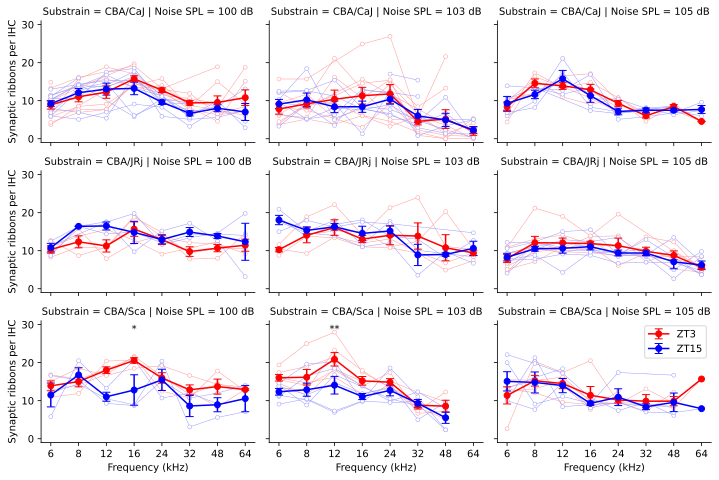

In [7]:
# plotting

colormap = {'baseline': [.4, .4, .4], 'ZT3': 'r', 'ZT15': 'b'}
pale_colormap = {'baseline': [.7, .7, .7], 'ZT3': [1, .6, .6], 'ZT15': [.6, .6, 1]}

# ax = plt.axes()
ribbons['freq_cat'] = ribbons['Frequency (kHz)'].astype('category')
ribbons['freq_cat'] = ribbons['freq_cat'].cat.rename_categories({6.: '6', 8.: '8', 12.: '12', 16.: '16', 24.: '24', 32.: '32', 48.: '48', 64.: '64'})

g = sns.relplot(x='freq_cat', y='Synaptic ribbons per IHC', hue='ZT', units='ID', estimator=None,
                row='Substrain', col='Noise SPL', hue_order=['baseline', 'ZT3', 'ZT15'],
                row_order=['CBA/CaJ', 'CBA/JRj', 'CBA/Sca'], col_order=['100 dB', '103 dB', '105 dB'],
                data=ribbons, kind='line', lw=.5, mew=.5, mfc='w', marker='o', ms=4, palette=pale_colormap,
                height=2.2, aspect=1.5, legend=False)

mean_sem = ribbons[['Substrain', 'Noise SPL', 'ZT', 'Frequency (kHz)', 'Synaptic ribbons per IHC']].groupby(by=['Substrain', 'Noise SPL', 'ZT', 'Frequency (kHz)']).agg(['mean', 'sem']).reset_index()
for ax in g.axes.flatten():
    clrs = [to_rgba(line.get_color()) for line in ax.lines]
    for c, v in enumerate(ax.lines):
        v.set_markeredgecolor(clrs[c])
    
    if 'CBA/CaJ' in ax.get_title():
        small_df = mean_sem[mean_sem['Substrain']=='CBA/CaJ']
    elif 'CBA/JRj' in ax.get_title():
        small_df = mean_sem[mean_sem['Substrain']=='CBA/JRj']
    elif 'CBA/Sca' in ax.get_title():
        small_df = mean_sem[mean_sem['Substrain']=='CBA/Sca']
    if '100 dB' in ax.get_title():
        small_df = small_df[small_df['Noise SPL']=='100 dB']
    elif '103 dB' in ax.get_title():
        small_df = small_df[small_df['Noise SPL']=='103 dB']
    elif '105 dB' in ax.get_title():
        small_df = small_df[small_df['Noise SPL']=='105 dB']
    for c, time in enumerate(['ZT3', 'ZT15']):  # enumerate(['baseline', 'ZT3', 'ZT15']):
        plot_df = small_df[small_df['ZT']==time]
        ax.errorbar(np.arange(0, len(plot_df)), plot_df['Synaptic ribbons per IHC']['mean'],
                    yerr=plot_df['Synaptic ribbons per IHC']['sem'], linewidth=1.5, capsize=4,
                    marker='o', markersize=6, zorder=1e3, label=time, color=colormap[time])

g.set(ylim=(-1, 31), xlabel='Frequency (kHz)', ylabel='Synaptic ribbons per IHC')

ax.legend()

all_ax = g.axes.flatten()
all_ax[6].annotate('*', [3, 28], ha='center')
all_ax[7].annotate('**', [2, 28], ha='center')

plt.show()


## Synapses

In [8]:
synapses_baseline = pd.read_csv('synapse_controls.csv', delimiter=',', header=None).T

# # rename columns
synapses_baseline.columns = synapses_baseline.iloc[0]
synapses_baseline.columns = synapses_baseline.columns.fillna('dummy')
synapses_baseline.columns.values[0] = 'Substrain'
synapses_baseline.columns.values[1] = 'ID'
synapses_baseline.drop(0, inplace=True)

# stack values
synapses_baseline = pd.DataFrame(synapses_baseline.set_index(['Substrain', 'ID']).stack())
synapses_baseline.columns = ['Synapses per IHC']
synapses_baseline.reset_index(inplace=True)
synapses_baseline.rename({0: 'Frequency (kHz)'}, axis=1, inplace=True)

# create other informative columns, and triple presence of curves for 'Noise SPL'
synapses_baseline['Noise SPL'] = '100 dB'
synapses_baseline['ZT'] = 'baseline'
temp = synapses_baseline.copy()
temp['Noise SPL'] = '103 dB'
synapses_baseline = synapses_baseline.append(temp)
temp['Noise SPL'] = '105 dB'
synapses_baseline = synapses_baseline.append(temp)

# correct data types
synapses_baseline = synapses_baseline.astype({'Frequency (kHz)': int, 'Synapses per IHC': float, 'ID': str,
                                              'Substrain': 'category', 'Noise SPL': 'category', 'ZT': 'category'})

synapses_baseline.head()

,Substrain,ID,Frequency (kHz),Synapses per IHC,Noise SPL,ZT
0,CBA/CaJ,C90,6,5.81,100 dB,baseline
1,CBA/CaJ,C90,8,3.90,100 dB,baseline
2,CBA/CaJ,C90,12,6.80,100 dB,baseline
3,CBA/CaJ,C90,16,15.10,100 dB,baseline
4,CBA/CaJ,C90,24,13.36,100 dB,baseline


In [9]:
# load data
synapses_treated = pd.read_csv('synapses_treated.csv', delimiter=',', header=None).T

# remove NaNs in column names
synapses_treated[0] = synapses_treated[0].fillna(method='ffill')

# rename columns
synapses_treated.columns = synapses_treated.iloc[0]
synapses_treated.drop(0, inplace=True)

# stack values
synapses_treated = pd.DataFrame(synapses_treated.set_index(['strain', 'ID']).stack())
synapses_treated.columns = ['Synapses per IHC']
synapses_treated.reset_index(inplace=True)
synapses_treated.rename({'strain': 'Group', 0: 'Frequency (kHz)'}, axis=1, inplace=True)

# create more informative columns
synapses_treated['Substrain'] = synapses_treated['Group'].apply(lambda s: s.split()[0])
synapses_treated['Noise SPL'] = synapses_treated['Group'].apply(lambda s: ' '.join(s.split()[1:3]) if len(s.split()) > 3 else s.split()[1])
synapses_treated['ZT'] = synapses_treated['Group'].apply(lambda s: s.split()[-1])

# replace values
synapses_treated = synapses_treated.replace({'day': 'ZT3', 'night': 'ZT15'})

# correct data types
synapses_treated = synapses_treated.astype({'Frequency (kHz)': int, 'Group': str, 'Synapses per IHC': float, 'ID': str,
                                            'Substrain': 'category', 'Noise SPL': 'category', 'ZT': 'category'})

synapses_treated.head()

,Group,ID,Frequency (kHz),Synapses per IHC,Substrain,Noise SPL,ZT
0,CBA/Sca 100 dB day,B51,6,7.4,CBA/Sca,100 dB,ZT3
1,CBA/Sca 100 dB day,B51,8,7.4,CBA/Sca,100 dB,ZT3
2,CBA/Sca 100 dB day,B51,12,12.3,CBA/Sca,100 dB,ZT3
3,CBA/Sca 100 dB day,B51,16,4.4,CBA/Sca,100 dB,ZT3
4,CBA/Sca 100 dB day,B51,24,6.1,CBA/Sca,100 dB,ZT3


In [10]:
# # merge baseline and treated
# synapses = pd.concat([synapses_treated, synapses_baseline])
synapses = synapses_treated

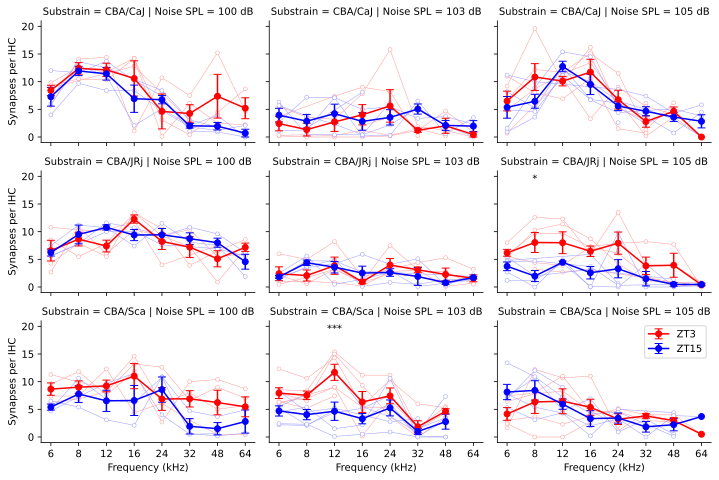

In [11]:
# plotting

colormap = {'baseline': [.4, .4, .4], 'ZT3': 'r', 'ZT15': 'b'}
pale_colormap = {'baseline': [.7, .7, .7], 'ZT3': [1, .6, .6], 'ZT15': [.6, .6, 1]}

# ax = plt.axes()
synapses['freq_cat'] = synapses['Frequency (kHz)'].astype('category')
synapses['freq_cat'] = synapses['freq_cat'].cat.rename_categories({6.: '6', 8.: '8', 12.: '12', 16.: '16', 24.: '24', 32.: '32', 48.: '48', 64.: '64'})

g = sns.relplot(x='freq_cat', y='Synapses per IHC', hue='ZT', units='ID', estimator=None,
                row='Substrain', col='Noise SPL', hue_order=['baseline', 'ZT3', 'ZT15'],
                row_order=['CBA/CaJ', 'CBA/JRj', 'CBA/Sca'], col_order=['100 dB', '103 dB', '105 dB'],
                data=synapses, kind='line', lw=.5, mew=.5, mfc='w', marker='o', ms=4, palette=pale_colormap,
                height=2.2, aspect=1.5, legend=False)

mean_sem = synapses[['Substrain', 'Noise SPL', 'ZT', 'Frequency (kHz)', 'Synapses per IHC']].groupby(by=['Substrain', 'Noise SPL', 'ZT', 'Frequency (kHz)']).agg(['mean', 'sem']).reset_index()
for ax in g.axes.flatten():
    clrs = [to_rgba(line.get_color()) for line in ax.lines]
    for c, v in enumerate(ax.lines):
        v.set_markeredgecolor(clrs[c])
    
    if 'CBA/CaJ' in ax.get_title():
        small_df = mean_sem[mean_sem['Substrain']=='CBA/CaJ']
    elif 'CBA/JRj' in ax.get_title():
        small_df = mean_sem[mean_sem['Substrain']=='CBA/JRj']
    elif 'CBA/Sca' in ax.get_title():
        small_df = mean_sem[mean_sem['Substrain']=='CBA/Sca']
    if '100 dB' in ax.get_title():
        small_df = small_df[small_df['Noise SPL']=='100 dB']
    elif '103 dB' in ax.get_title():
        small_df = small_df[small_df['Noise SPL']=='103 dB']
    elif '105 dB' in ax.get_title():
        small_df = small_df[small_df['Noise SPL']=='105 dB']
    for c, time in enumerate(['ZT3', 'ZT15']):  # enumerate(['baseline', 'ZT3', 'ZT15']):
        plot_df = small_df[small_df['ZT']==time]
        ax.errorbar(np.arange(0, len(plot_df)), plot_df['Synapses per IHC']['mean'],
                    yerr=plot_df['Synapses per IHC']['sem'], linewidth=1.5, capsize=4,
                    marker='o', markersize=6, zorder=1e3, label=time, color=colormap[time])

g.set(ylim=(-1, 21), xlabel='Frequency (kHz)', ylabel='Synapses per IHC')

ax.legend()

all_ax = g.axes.flatten()
all_ax[5].annotate('*', [1, 19], ha='center')
all_ax[7].annotate('***', [2, 19], ha='center')

plt.show()


# Wave 1

In [12]:
wave1 = pd.read_csv('abr_data.csv')
wave1 = wave1[wave1['Level_dB']==70]
wave1 = wave1[wave1['ABRtime']!='baseline']
wave1.drop(labels=['ABRtime', 'W1amp_normalized', 'RLM', 'RLM_error', 'RLM_error_normalized',
                   'conf_interval_low', 'conf_interval_high', 'W1amp_no_outliers',
                   'is_threshold', 'filename', 'waveform', 'time'], axis=1, inplace=True)
wave1.head()

,supplier,ID,special,noiseSPL,analyzer_ID,experimenter_ID,NoiseType,Level_dB,Freq_Hz,W1amp,is_outlier,threshold
37,Jackson,C203_5,none,100,JF,JF,ZT15,70.0,32000,63.460,False,30.0
947,Jackson,C44_5,none,100,CV,RP,ZT3,70.0,8000,678.085,False,20.0
953,Jackson,C44_5,none,100,CV,RP,ZT3,70.0,32000,591.906,False,65.0
959,Jackson,C44_5,none,100,CV,RP,ZT3,70.0,24000,499.898,False,65.0
968,Jackson,C44_5,none,100,CV,RP,ZT3,70.0,16000,613.311,False,50.0


In [13]:
ribsyn = ribbons.merge(synapses, on=['ZT', 'ID', 'Frequency (kHz)', 'Substrain', 'Noise SPL'], how='outer')
ribsyn.drop(['Group_x', 'Group_y', 'freq_cat_x', 'freq_cat_y'], axis=1, inplace=True)
ribsyn.rename({'Substrain_x': 'Substrain', 'Noise SPL_x': 'Noise SPL'}, inplace=True, axis=1)
ribsyn = ribsyn[~ribsyn.duplicated(['ID', 'ZT', 'Frequency (kHz)'])]
ribsyn.head()

,ID,Frequency (kHz),Synaptic ribbons per IHC,Substrain,Noise SPL,ZT,Synapses per IHC
0,B51,6,10.9,CBA/Sca,100 dB,ZT3,7.4
1,B51,8,11.9,CBA/Sca,100 dB,ZT3,7.4
2,B51,12,20.4,CBA/Sca,100 dB,ZT3,12.3
3,B51,16,20.7,CBA/Sca,100 dB,ZT3,4.4
4,B51,24,15.8,CBA/Sca,100 dB,ZT3,6.1


In [14]:
def select_data(df, **kwargs):
    if kwargs is not None:
        for key, value in kwargs.items():
            if np.size(value) == 1:
                df = df[df[key] == value]
            else:
                df = df.iloc[[v in value for v in df[key]]]
    return df

id_conversion = {}
for row in ribsyn.iterrows():
    wave_id = wave1[wave1['ID'].str.contains(row[1]['ID'], regex=False)]['ID'].unique()
    if row[1]['ID'] not in id_conversion and len(wave_id)>0:
        id_conversion[row[1]['ID']] = wave_id[0]
# manual corrections
id_conversion['C36'] = 'C36_3'
id_conversion['C39'] = 'C39_3'
id_conversion.pop('C21')

'C210_2'

In [15]:
ribsyn['wave1_id'] = ribsyn['ID'].map(id_conversion)
wave1['Freq_Hz'] /= 1e3
wave1['Freq_Hz'] = wave1['Freq_Hz'].astype(int)
ribsyn['Frequency (kHz)'] = ribsyn['Frequency (kHz)'].astype(int)

ribsyn = ribsyn.merge(wave1,
                      left_on=['wave1_id', 'Frequency (kHz)', 'ZT'],
                      right_on=['ID', 'Freq_Hz', 'NoiseType'],
                      how='left')

In [16]:
ribsyn.drop(['ID_x', 'supplier', 'ID_y', 'special', 'noiseSPL',
             'analyzer_ID', 'experimenter_ID', 'NoiseType',
             'Level_dB', 'Freq_Hz'], axis=1, inplace=True)
ribsyn.rename({'wave1_id': 'ID'}, axis=1, inplace=True)
ribsyn

,Frequency (kHz),Synaptic ribbons per IHC,Substrain,Noise SPL,ZT,Synapses per IHC,ID,W1amp,is_outlier,threshold
0,6,10.9,CBA/Sca,100 dB,ZT3,7.4,B51_5,NaN,NaN,NaN
1,8,11.9,CBA/Sca,100 dB,ZT3,7.4,B51_5,685.672,False,25.0
2,8,11.9,CBA/Sca,100 dB,ZT3,7.4,B51_5,621.000,False,10.0
3,12,20.4,CBA/Sca,100 dB,ZT3,12.3,B51_5,1326.551,False,40.0
4,12,20.4,CBA/Sca,100 dB,ZT3,12.3,B51_5,809.203,False,5.0
...,...,...,...,...,...,...,...,...,...,...
969,6,NaN,CBA/CaJ,105 dB,ZT15,11.2,C62_5,NaN,NaN,NaN
970,32,NaN,CBA/CaJ,105 dB,ZT15,7.4,C62_5,428.501,False,50.0
971,64,NaN,CBA/CaJ,105 dB,ZT15,5.8,C62_5,NaN,NaN,NaN
972,24,NaN,CBA/CaJ,105 dB,ZT15,2.6,C275_1,68.356,False,60.0


In [17]:
ribsyn_pivoted = pd.pivot_table(ribsyn,
                                columns=['Substrain', 'Noise SPL', 'ZT', 'ID'],
                                index='Frequency (kHz)',
                                values=['W1amp', 'Synaptic ribbons per IHC', 'Synapses per IHC'])
 
ribsyn_pivoted.to_csv('ribbons_synapses_wave1.csv')

ribsyn_pivoted

Synapses per IHC                                      \
Substrain                CBA/CaJ                                       
Noise SPL                 100 dB                                       
ZT                          ZT15                           ZT3         
ID                         C22_2  C34_1 C36_3 C39_3      C40_1 C41_2   
Frequency (kHz)                                                        
6                      12.000000   6.00   4.0   7.1   9.800000   5.7   
8                      11.636364  12.80   9.7  13.6  12.600000  14.1   
12                     13.700000  11.10   8.4  12.5  11.700000  14.4   
16                     10.250000   2.11   8.4   NaN  14.250000   1.1   
24                      7.400000   5.10   4.8   8.4   3.083333  10.7   
32                      1.100000   2.11   1.8   3.1   0.400000   7.5   
48                      0.900000   3.90   1.2   1.8   4.400000  15.2   
64                      0.000000   0.00   2.1   NaN   8.700000   4.7   

                                                ...    W1amp             \
Substrain                                       ...  CBA/Sca              
Noise SPL                        103 dB         ...   105 dB              
ZT                                 ZT15         ...     ZT15              
ID                   C42_3 C44_5 C100_2 C101_3  ...   B372_2  x192163_1   
Frequency (kHz)                                 ...                       
6                 9.285714   8.9    1.1    6.3  ...      NaN        NaN   
8                10.500000   NaN    1.3    0.4  ...  285.743  1008.3130   
12               10.300000   NaN    7.1    0.4  ...  200.826   805.1305   
16               14.200000  12.8    0.2    0.4  ...      NaN   847.4855   
24                0.100000   NaN    0.3    2.2  ...      NaN   591.4945   
32                6.100000   3.0    6.5    5.3  ...      NaN        NaN   
48                2.500000   NaN    0.6    2.0  ...      NaN        NaN   
64                2.200000   NaN    3.5    0.1  ...      NaN        NaN   

                                                                             \
Substrain                                                                     
Noise SPL                                                                     
ZT                                                  ZT3                       
ID              x192164_2 x192165_3 x192167_5    B343_1    B344_2    B346_4   
Frequency (kHz)                                                               
6                     NaN       NaN       NaN       NaN       NaN       NaN   
8                 47.0010   336.610   600.361  383.0165  576.6645  422.5985   
12               435.3390   849.113   541.441  325.3750  534.2370  626.0810   
16               524.8310   963.528   683.562  333.0555  430.2750  753.2290   
24               146.7865   483.555   442.661  170.2170  311.5430  240.3425   
32               468.4300       NaN   218.215  140.2875  229.8760       NaN   
48                    NaN       NaN       NaN       NaN       NaN       NaN   
64                    NaN       NaN       NaN       NaN       NaN       NaN   

                                     
Substrain                            
Noise SPL                            
ZT                                   
ID                 B347_5    B351_1  
Frequency (kHz)                      
6                     NaN       NaN  
8                481.0520  397.5120  
12               336.8735  398.9645  
16               538.9020  699.6140  
24                    NaN  536.9890  
32                    NaN  579.7530  
48                    NaN       NaN  
64                    NaN       NaN  

[8 rows x 278 columns]